In [1]:
from model.model import RecommenderSystemModel
from utils import get_categories, get_vector_diff_df, plot_book_distribution_by_genre
from data.data_preparation import get_model_df, get_items_df, get_users_df
from datetime import date
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import os
import itertools
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
# Sensitivity analysis configuration

steps = 360
run_type = "sensitivity"
today = date.today()

priority = [i/100 for i in range(0, 105, 10)] + get_categories()
ignorant_proportion = [0.5, 1.0]
social_influence = [False, True]

experimental_setups = itertools.product(priority, ignorant_proportion, social_influence)
experimental_setup = [
    {
        "priority": comb[0], 
        "ignorant_proportion": comb[1], 
        "social_influence": comb[2]
    } for comb in experimental_setups
]

fixed_setup = {
    "n_users": 150,
    "seed": 256788
}

In [3]:
# Static data gathering

df = get_model_df(**fixed_setup)
df.to_csv(f"data/sensitivity/static_sensitivity_df_{today}.csv")

Loading data...
    - Users loaded
    - Items loaded
    - Model dataframe ready. Interactions: 5757


In [4]:
# Simulation runs

if "df" not in globals():
    df = pd.read_csv(f"data/sensitivity/static_sensitivity_df_{today}.csv")

fixed_setup.update({"steps": steps, "df": df, "run_type": run_type})

for experiment in experimental_setup:
    run_setup = fixed_setup.copy()
    run_setup.update(experiment)
    print(f"Running experimental setup: {experiment}\n")
    rec_sys = RecommenderSystemModel(**run_setup)
    rec_sys.run_model()
print("\nSensitivity Analysis Finished!")

Running experimental setup: {'priority': 0.0, 'ignorant_proportion': 0.5, 'social_influence': False}

Running experimental setup: {'priority': 0.0, 'ignorant_proportion': 0.5, 'social_influence': True}

Running experimental setup: {'priority': 0.0, 'ignorant_proportion': 1.0, 'social_influence': False}

Running experimental setup: {'priority': 0.0, 'ignorant_proportion': 1.0, 'social_influence': True}

Running experimental setup: {'priority': 0.1, 'ignorant_proportion': 0.5, 'social_influence': False}

Running experimental setup: {'priority': 0.1, 'ignorant_proportion': 0.5, 'social_influence': True}

Running experimental setup: {'priority': 0.1, 'ignorant_proportion': 1.0, 'social_influence': False}

Running experimental setup: {'priority': 0.1, 'ignorant_proportion': 1.0, 'social_influence': True}

Running experimental setup: {'priority': 0.2, 'ignorant_proportion': 0.5, 'social_influence': False}

Running experimental setup: {'priority': 0.2, 'ignorant_proportion': 0.5, 'social_infl

Standard deviation for max: 310.58127626543535
Coefficient of variation for max: 0.823686461171385


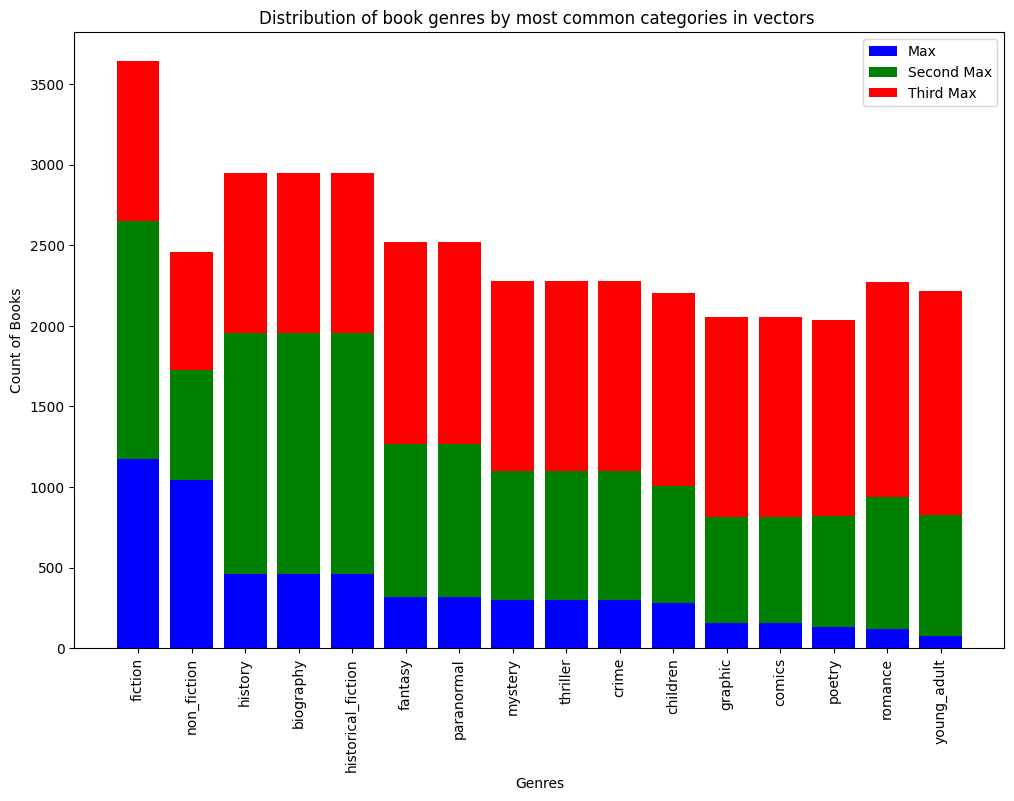

In [2]:
# Data exploration

# Plot distribution of books per genre

df_items = pd.read_csv("data/sensitivity/2024-06-19_01/initial_items_1.csv")
plot_book_distribution_by_genre(df_items, stats="max")

Standard deviation for max: 455.1641474225547
Coefficient of variation for max: 0.4205304602333377


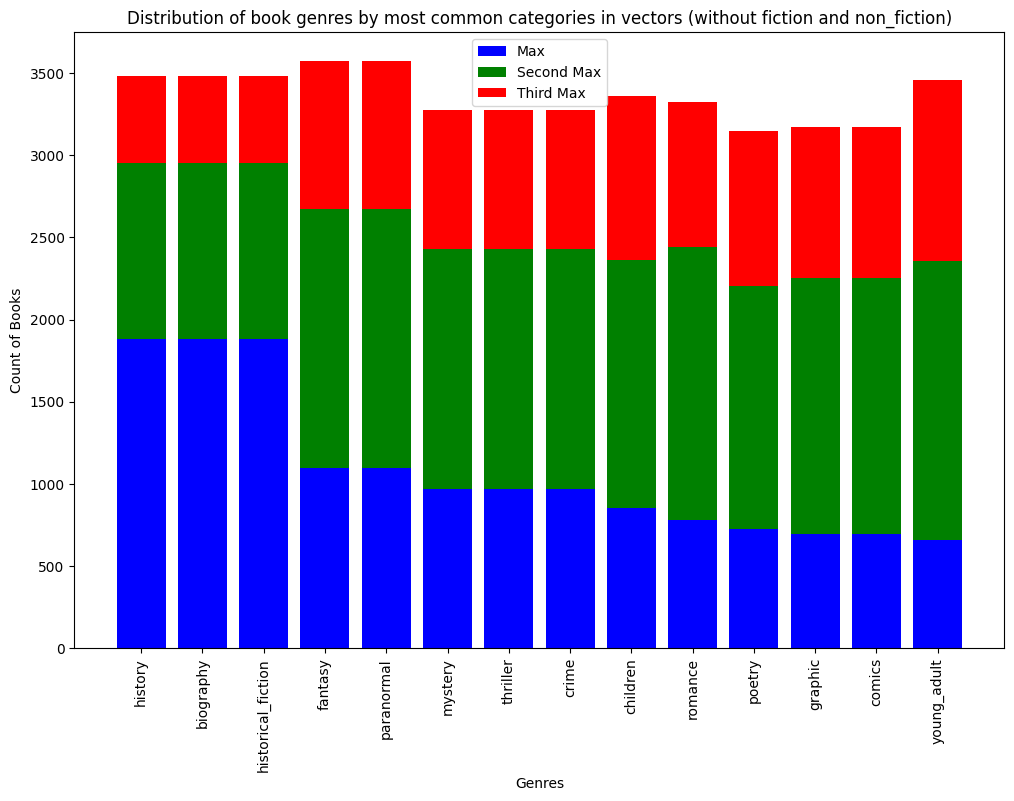

In [3]:
# Plot distribution without fiction and non_fiction categories

plot_book_distribution_by_genre(df_items, filtered=True, stats="max")

In [13]:
# Data analysis

# Data extraction

dfs = []
base_path = "data/sensitivity"
entries = sorted(os.listdir(base_path))
i = 1

for entry, experiment in zip(entries, experimental_setup):
    full_path = os.path.join(base_path, entry)
    if os.path.isdir(full_path):
        results_path = os.path.join(full_path, "run_raw_1.csv")
        df_vectors = get_vector_diff_df(results_path)
        df_vectors["priority"] = experiment["priority"]
        df_vectors["ignorant_proportion"] = experiment["ignorant_proportion"]
        df_vectors["social_influence"] = experiment["social_influence"]
        dfs.append(df_vectors)
        print(f"Processed Dataframe {i}/{len(experimental_setup)}", end="\r")
        i += 1

df_all_vector_diff = pd.concat(dfs, ignore_index=True)

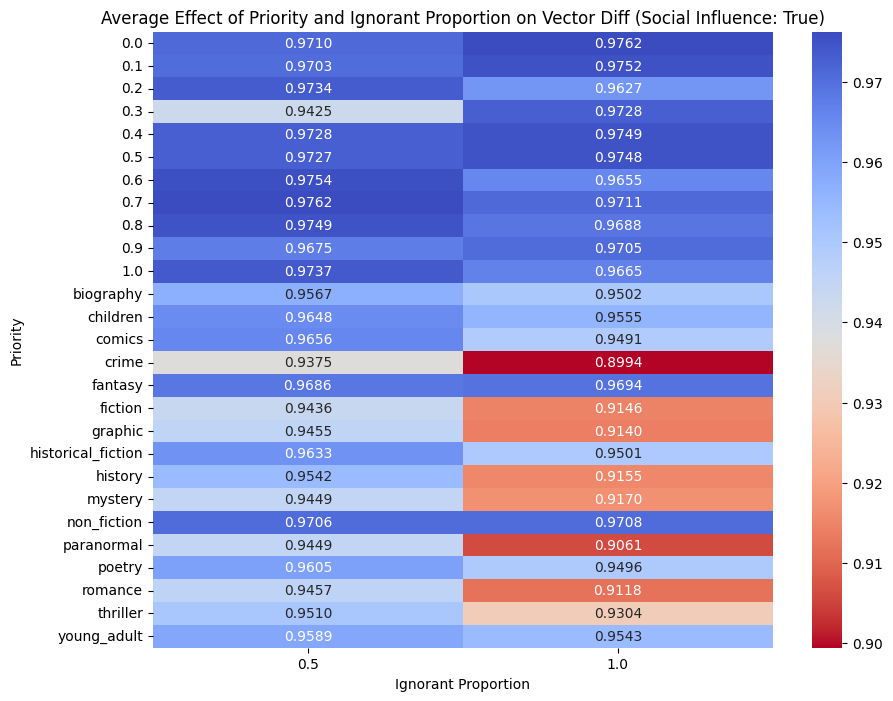

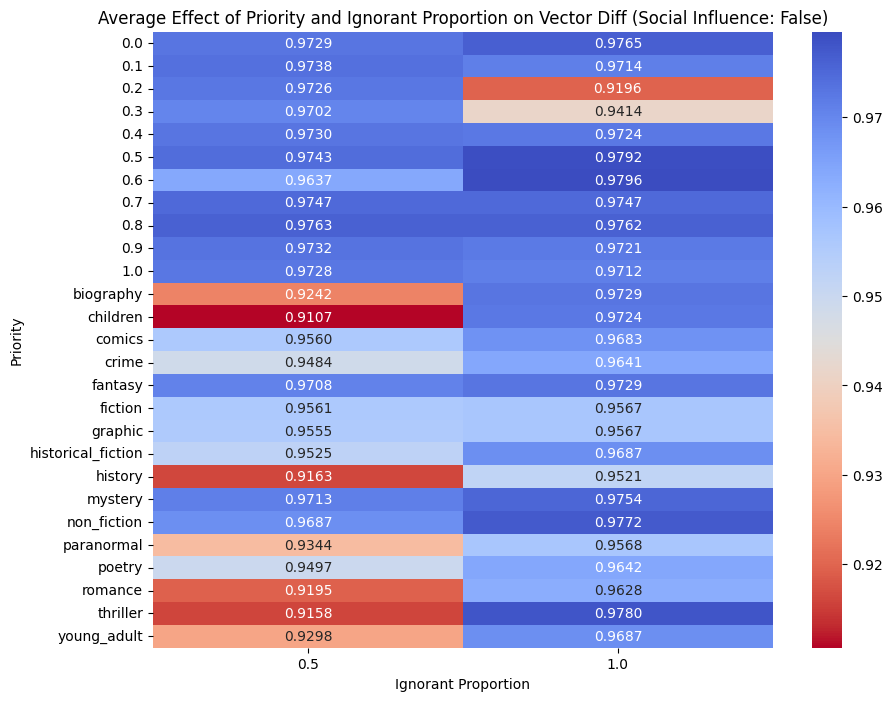

In [14]:
# Plot average differences

# Heatmaps

for soc_inf in [True, False]:
    
    filtered_data = df_all_vector_diff[df_all_vector_diff['social_influence'] == soc_inf]
    
    heatmap_data = filtered_data.pivot_table(
        index='priority', 
        columns='ignorant_proportion', 
        values='vector_diff', 
        aggfunc='mean'  
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm_r", fmt=".4f")
    plt.title(f"Average Effect of Priority and Ignorant Proportion on Vector Diff (Social Influence: {soc_inf})")
    plt.xlabel("Ignorant Proportion")
    plt.ylabel("Priority")
    plt.show()

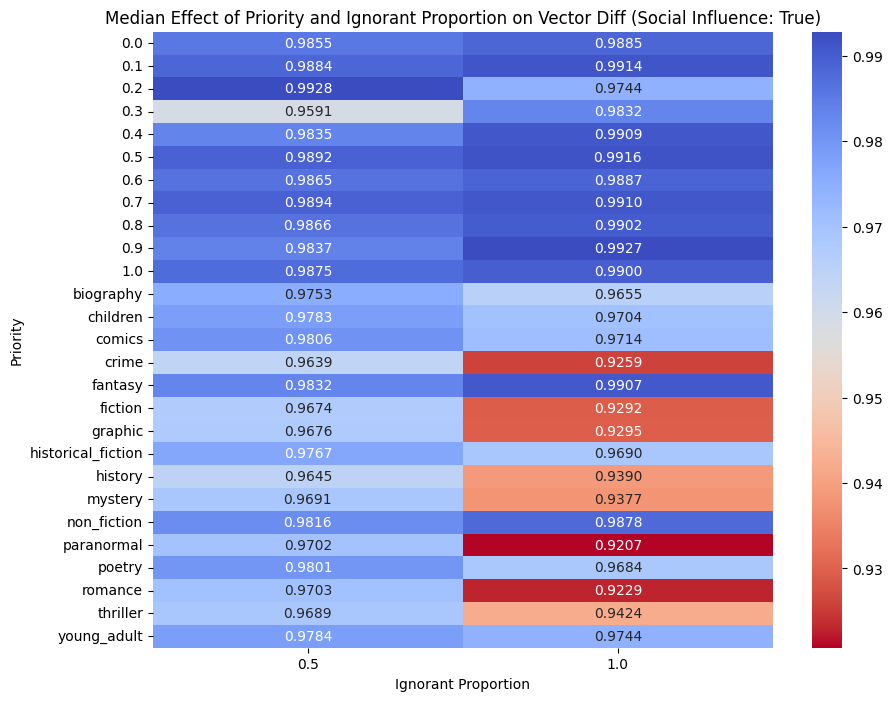

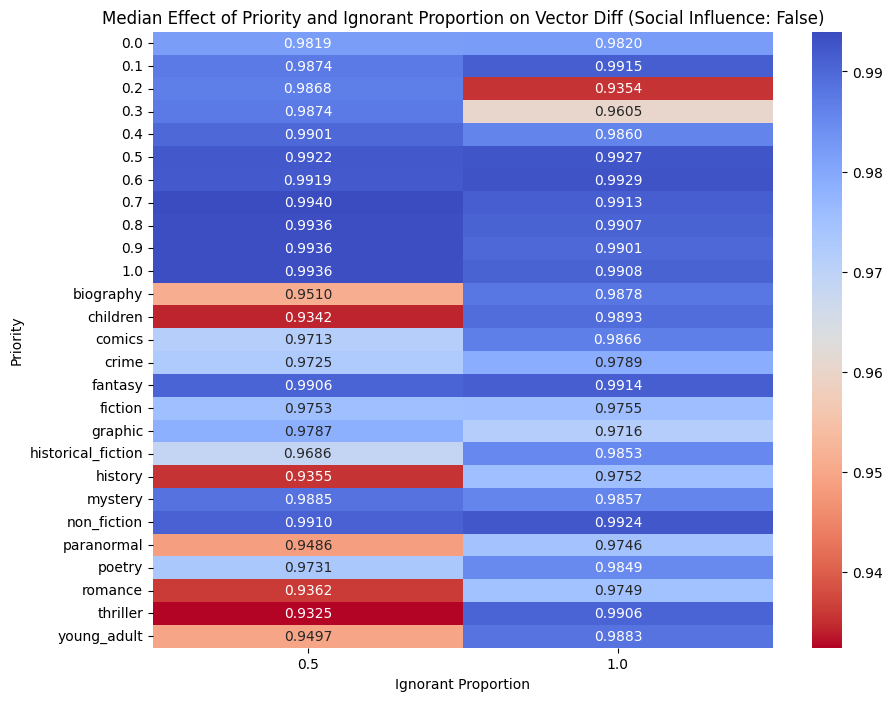

In [15]:
# Plot median differences

# Heatmaps

for soc_inf in [True, False]:
    
    filtered_data = df_all_vector_diff[df_all_vector_diff['social_influence'] == soc_inf]
    
    heatmap_data = filtered_data.pivot_table(
        index='priority', 
        columns='ignorant_proportion', 
        values='vector_diff', 
        aggfunc='median'  
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm_r", fmt=".4f")
    plt.title(f"Median Effect of Priority and Ignorant Proportion on Vector Diff (Social Influence: {soc_inf})")
    plt.xlabel("Ignorant Proportion")
    plt.ylabel("Priority")
    plt.show()